In [1]:
# making training data from annotations

In [215]:
## Import libraries

# general
import os
import glob
from tqdm.notebook import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt

# rasters
import rasterio

# shapes
import fiona
import shapefile
import shapely
from shapely.geometry import shape, Polygon, box, MultiPolygon
from shapely.ops import cascaded_union, unary_union

# for transormations
import pyproj
from shapely.ops import transform
from functools import partial

# 
from rasterio.mask import mask
from skimage import exposure

In [216]:
# load helper functions

def wgs2epsgzone(x,y):
    EPSG = 32700-round((45+y)/90,0)*100+round((183+x)/6,0)
    UTM_EPSG_code = EPSG
    
    return int(UTM_EPSG_code)

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list

In [217]:
# set parameters

chunk_size_pix = 400

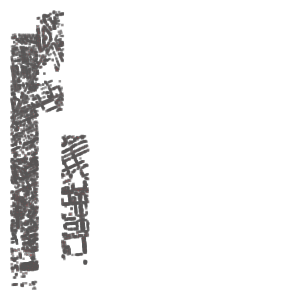

In [218]:
# alternative shapefile reading
sf = shapefile.Reader(annotations_shape_files[0])
shapes = sf.shapes()

MultiPolygon([shape(pol) for pol in shapes])

number of annotations:  4946


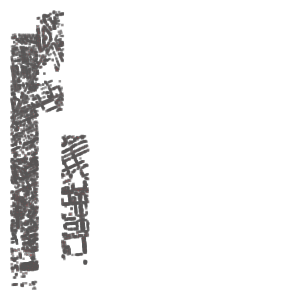

In [219]:
# find all files in folders for specific classes
# find current working directory 
cwd = os.getcwd()

# define paths with training data polygons
annotations_file_path = '../../../data/data_merged/annotations/*.shp'
# define paths with raster data
rasters_file_path = '../../../data/data_merged/tif/*.tif'

# find files in shapefile folder
annotations_shape_files = glob.glob(annotations_file_path)


# find files in raster folder
raster_files = glob.glob(rasters_file_path)


raster_files, annotations_shape_files

# load annotations

annotations_valid_shape_list = check_valid_geometries(annotations_shape_files[0])

# convert list to shapely MultiPolgyons
annotations_MultiPoly = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(annotations_shape_files[0])])


print('number of annotations: ', len(annotations_MultiPoly))

# load raster data
dataset = rasterio.open(raster_files[0])

annotations_MultiPoly

In [220]:
dataset.meta['crs'].to_epsg()

32631

In [221]:
x_min, y_min, x_max, y_max = annotations_MultiPoly.bounds

In [222]:
# clip raster file to annotation extend

chunk_bbox_org = box(x_min, y_min, x_max, y_max)
out_img, out_transform = mask(dataset, shapes=[chunk_bbox_org], crop=True)

In [223]:
dataset.shape[0] / (400 - 20)

32.06578947368421

In [224]:
out_img.shape

(8, 12081, 3364)

In [225]:
## get raster bbox
# convert bounds to polygon
left, bottom, right, top = dataset.bounds
poly_raster_bounds = Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])

In [226]:
# check raster crs
raster_crs = dataset.meta['crs'].to_epsg()

print(raster_crs)

annotations_MultiPoly_union = unary_union(annotations_MultiPoly)
    
total_n = len(annotations_MultiPoly_union)
overlap_n = len(poly_raster_bounds.intersection(annotations_MultiPoly_union))
    
# check if overlap is complete
if  overlap_n == total_n:
    print('datasets overlap entirely')
else:
    print('Datasets do not completely overlap')
    print('Overlap is:' ,round(overlap_n/total_n,3)*100, '% ', overlap_n, '/', total_n)

32631
datasets overlap entirely


In [227]:
x_pix_size_m = dataset.meta['transform'].a

y_pix_size_m = dataset.meta['transform'].e



x_chunk_size_m = abs(chunk_size_pix * x_pix_size_m)
y_chunk_size_m = abs(chunk_size_pix * y_pix_size_m)

n_x_chunks = (right - left) / x_chunk_size_m
n_y_chunks = (top - bottom) / y_chunk_size_m

frac_rest_x = math.ceil(n_x_chunks) - n_x_chunks

x_chunk_size_m, y_chunk_size_m, n_x_chunks, frac_rest * x_chunk_size_m / math.floor(n_x_chunks)

(145.2247964338791, 145.22479770207534, 8.4125, 10.664945988113004)

In [228]:
x_chunk_list = np.linspace(0,n_x_chunks * x_chunk_size_m,n_x_chunks + 1,endpoint=True)
y_chunk_list = np.linspace(0,n_y_chunks * y_chunk_size_m,n_y_chunks + 1,endpoint=True)

total_chunk_nr = (len(x_chunk_list) - 1) * (len(y_chunk_list) - 1)

x_chunk_list, y_chunk_list

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

In [ ]:
dataset.shape

In [ ]:
n_x_chunks

In [229]:
n_x_chunks = (right - left) / x_chunk_size_m
n_y_chunks = (top - bottom) / y_chunk_size_m

In [230]:
n_y_chunks

30.4625

(197, 173, 3)
| 0.36, 0.00, 626432.35|
| 0.00,-0.36, 5800277.88|
| 0.00, 0.00, 1.00|


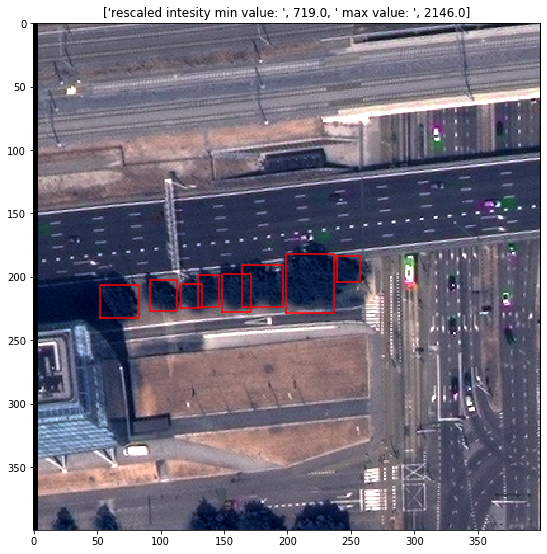

(400, 400, 3)
| 0.36, 0.00, 626432.35|
| 0.00,-0.36, 5800567.97|
| 0.00, 0.00, 1.00|


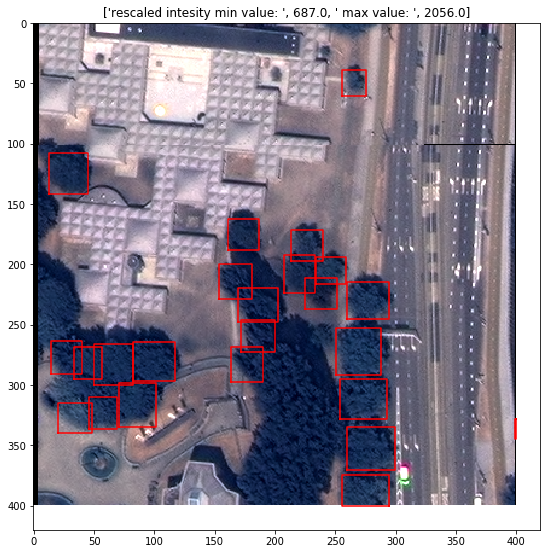

(400, 400, 3)
| 0.36, 0.00, 626432.35|
| 0.00,-0.36, 5801003.28|
| 0.00, 0.00, 1.00|


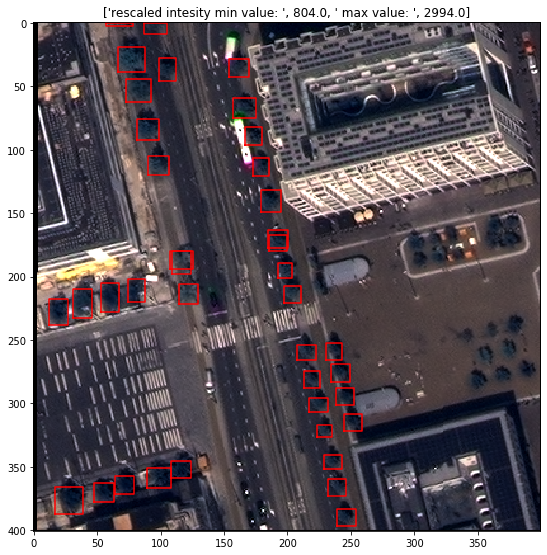

(401, 400, 3)
| 0.36, 0.00, 626432.35|
| 0.00,-0.36, 5801583.45|
| 0.00, 0.00, 1.00|


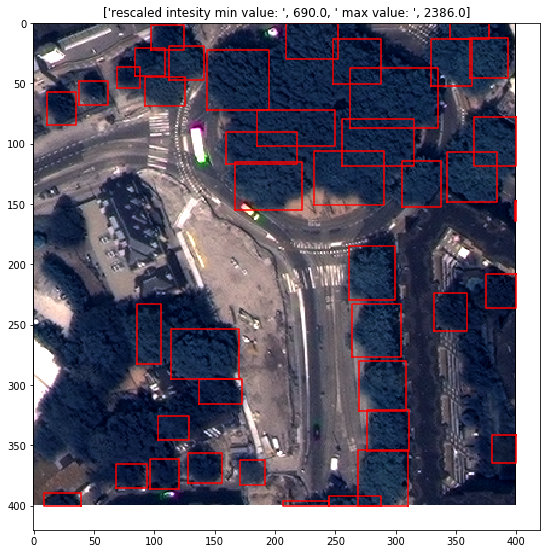

(400, 400, 3)
| 0.36, 0.00, 626577.21|
| 0.00,-0.36, 5801728.68|
| 0.00, 0.00, 1.00|


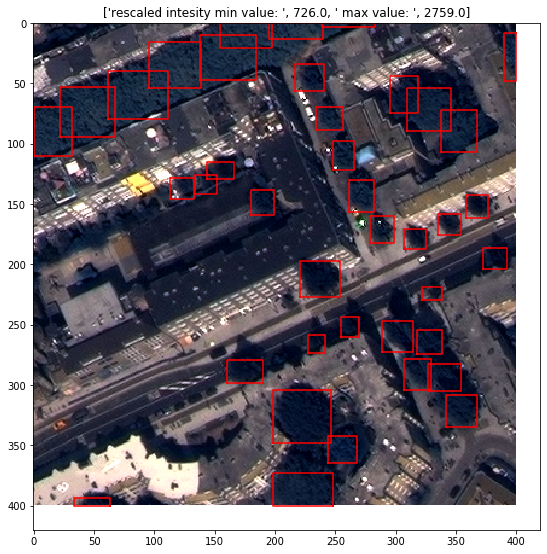

(400, 400, 3)
| 0.36, 0.00, 626722.07|
| 0.00,-0.36, 5802018.76|
| 0.00, 0.00, 1.00|


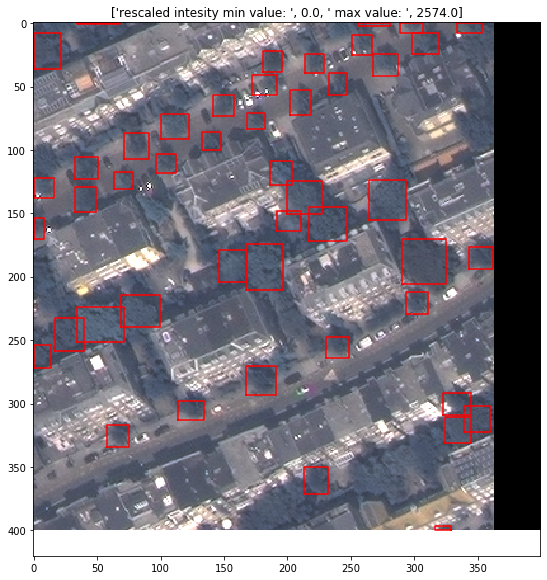

(400, 400, 3)
| 0.36, 0.00, 626866.93|
| 0.00,-0.36, 5802454.07|
| 0.00, 0.00, 1.00|


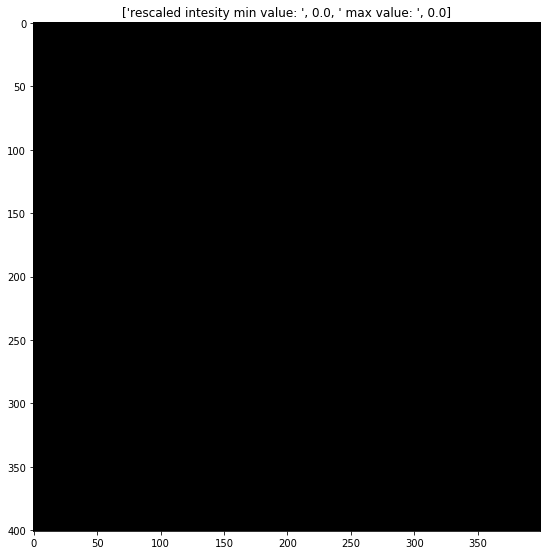

(401, 400, 3)
| 0.36, 0.00, 627011.79|
| 0.00,-0.36, 5803034.25|
| 0.00, 0.00, 1.00|


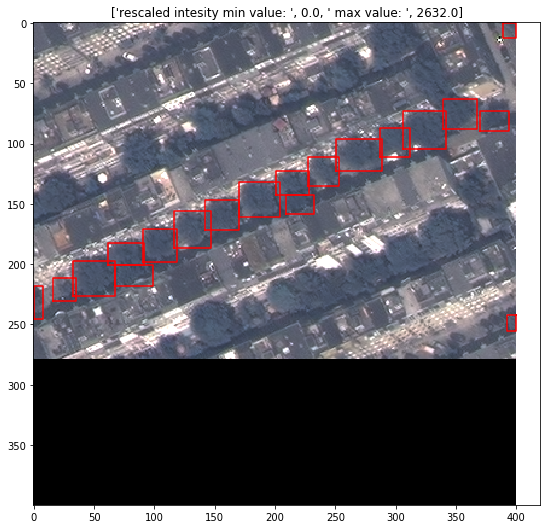

(400, 400, 3)
| 0.36, 0.00, 627301.52|
| 0.00,-0.36, 5803179.47|
| 0.00, 0.00, 1.00|


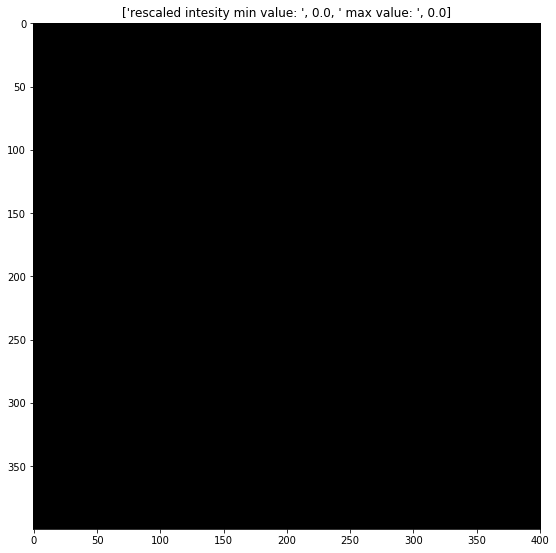

(400, 401, 3)
| 0.36, 0.00, 627591.24|
| 0.00,-0.36, 5803469.56|
| 0.00, 0.00, 1.00|


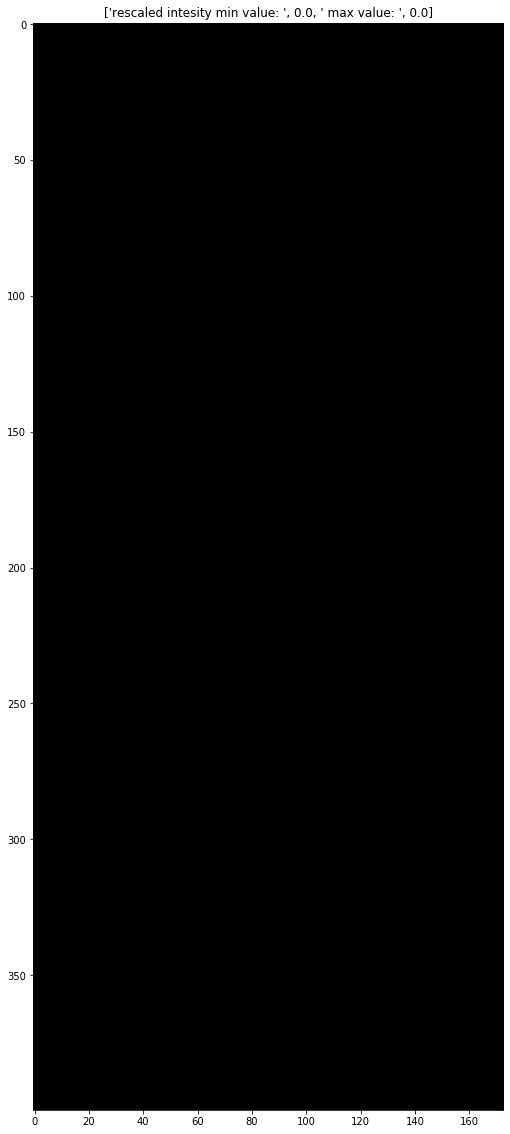

ValueError: Input shapes do not overlap raster.

In [231]:
# loop over chunks 


for i_x in tqdm(range(5 - 1)):
    for i_y in tqdm(range(5 - 1)):
        
        # convert chunk coordinates to bbox
        x_min = left + x_chunk_list[i_x]
        x_max = left + x_chunk_list[i_x + 1] 
        y_min = bottom + y_chunk_list[i_y]
        y_max = bottom + y_chunk_list[i_y + 1]
        
        chunk_bbox = box(x_min, y_min, x_max, y_max)
         
        # clip raster file 
        out_img, out_transform = mask(dataset, shapes=[chunk_bbox], crop=True)
        
        # check chunk size 
        print(img_plot.shape)
        print(out_transform)
        
        # get image data
        img_plot = out_img[2:5,:,:][::-1,:,:]
        img_plot = np.rot90(np.fliplr(img_plot.T))
        
        p1, p99 = np.percentile(img_plot, (2, 99))
        img_plot1 = exposure.rescale_intensity(img_plot, in_range=(p1, p99))
     
        img_plot2 = exposure.rescale_intensity(img_plot, in_range=(p1, p99))
        
        plt.figure(figsize = (20,20))
        plt.subplot(121)
        plt.title(['rescaled intesity min value: ', p1, ' max value: ', p99])
        plt.imshow(img_plot2)
        
        

        # write raster file to .tif or .png
        
        
        # loop over tree bboxes
        
        left = out_transform[2]
        bottom = out_transform[5]
        right = out_transform[2] + (img_plot.shape[0] * out_transform[0])
        top = out_transform[5] + (img_plot.shape[1] * out_transform[4])

        poly_raster_bounds = Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])
        
        chunk_MultiPoly = MultiPolygon([poly_raster_bounds.intersection(poly) for poly in annotations_MultiPoly])
        
        x = abs([poly.exterior.coords.xy[0] for poly in chunk_MultiPoly] - left) * 1/out_transform[0]
        y = abs([poly.exterior.coords.xy[1] for poly in chunk_MultiPoly] - bottom) * 1 / out_transform[0]
        
        for i in range(len(x)):
            plt.plot(x[i],y[i], color = 'red')

        
        plt.show()
        

        # recalculate tree annotation coordinates to pixel values on chunk
        
        
        # create string from tree annotation data
        
        # write string to csv
        
        
        

In [212]:
out_img.shape

(8, 197, 173)

In [174]:
plt.Rectangle((row['xmin'],row['ymin']),(row['xmax']-row['xmin']),(row['ymax']-row['ymin']), 
                                  linewidth=2,edgecolor='b',facecolor='none', alpha = 0.5, label = 'prediction')

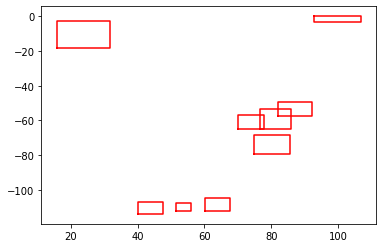

In [178]:
for i in range(len(x)):
    plt.plot(x[i],y[i], color = 'red')

In [150]:
out_transform[2]

Affine(0.3630619910846978, 0.0, 626432.3458,
       0.0, -0.3630619942551883, 5800277.880797703)

(array([      0.,       0.,       0.,       0.,       0., 1280000.,
              0.,       0.,       0.,       0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

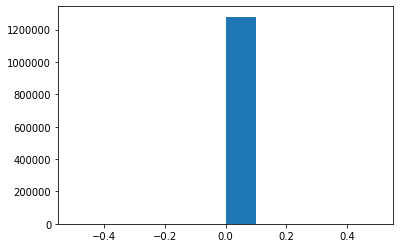

In [43]:
img_plot

array([[[19.        , 19.        , 19.        ],
        [19.        , 19.        , 19.        ],
        [19.        , 19.        , 19.        ],
        ...,
        [19.        , 19.        , 19.        ],
        [19.        , 19.        , 19.        ],
        [19.        , 19.        , 19.        ]],

       [[19.        , 19.        , 19.        ],
        [19.17227783, 19.21231423, 19.27691841],
        [19.32393085, 19.38398544, 19.48589627],
        ...,
        [19.12162572, 19.14134061, 19.16863816],
        [19.1006976 , 19.11950258, 19.14467698],
        [19.        , 19.        , 19.        ]],

       [[19.        , 19.        , 19.        ],
        [19.19441917, 19.24052169, 19.31483167],
        [19.33970276, 19.40552017, 19.51380042],
        ...,
        [19.11495299, 19.13284804, 19.15741583],
        [19.10009099, 19.11646952, 19.13952078],
        [19.        , 19.        , 19.        ]],

       ...,

       [[19.        , 19.        , 19.        ],
        [19

In [110]:
import matplotlib.pyplot as plt

In [31]:
img_plot.T.shape

(704, 704, 3)

## Test code


In [ ]:
epsg_code_int = wgs2epsgzone(left, top)

# define transformations
project_WGS2UTM = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:%i'  % (epsg_code_int)))

project_UTM2WGS = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:%i'  % (epsg_code_int)),
    pyproj.Proj(init='epsg:4326'))

# perform transformatios
bbox_poly_wgs = Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])

In [ ]:
# if raster crs is not WGS84, transform to WGS84
if raster_crs != 4326:
    
    project_org2WGS = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:%i'  % (raster_crs)),
        pyproj.Proj(init='epsg:4326'))
    
    project_WGS2org = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:%i'  % (raster_crs)))
    
    poly_raster_bounds_wgs = transform(project_org2WGS, poly_raster_bounds)
else: 
    poly_raster_bounds_wgs = poly_raster_bounds